# Load combined data csv file

In [1]:
# pip install numpy==1.19.5  <-- needed numpy 1.19.5 to run LSTM function

In [2]:
# import all necessary libraries
import requests
import json
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
print(np.__version__)

1.19.5


In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [5]:
# import FB Prophet libraries
from fbprophet import Prophet as proph
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [6]:
# import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

In [7]:
# import LSTM libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

In [9]:
# this is not necessary but helps to run notebook faster
%config Completer.use_jedi = False

In [10]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [11]:
#Clear warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Set styles of visualizations
sns.set_style('darkgrid')
sns.set_context('poster')

In [13]:
pd.set_option("display.max_columns", 50)

In [14]:
combined = pd.read_csv('data/combined.csv')

In [15]:
# drop column 'Unnamed: 0'
combined.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
combined.shape

(26665, 28)

In [17]:
# change column 'Sale Date' to datetime
combined['sale_date'] = pd.to_datetime(combined['sale_date'], infer_datetime_format=True)

In [18]:
combined.columns

Index(['sale_date', 'item_name', 'quantity', 'transaction_id', 'listing_id',
       'ship_city', 'ship_state', 'ship_zipcode', 'ship_country', 'order_id',
       'variations', 'state', 'user_id', 'category_id', 'title', 'description',
       'tags', 'shop_section_id', 'featured_rank', 'views', 'num_favorers',
       'occasion', 'style', 'is_customizable', 'has_variations', 'taxonomy_id',
       'taxonomy_path', 'main_tag'],
      dtype='object')

# Modeling for Category 1 data

In [19]:
cat_data = combined[combined.main_tag == 'cat_1'].groupby('sale_date')['quantity'].sum()

In [20]:
cat_data = pd.DataFrame(cat_data)

In [21]:
len(cat_data)

348

Looks like there were days when this category hasn't been bought. Need to fill in the missing dates with 0

In [22]:
cat_data.sum()

quantity    3399
dtype: int64

In [23]:
dates = pd.date_range(start='2020-01-01', end='2020-12-31')
type(dates)

pandas.core.indexes.datetimes.DatetimeIndex

In [24]:
dates = pd.DataFrame(dates)

In [25]:
dates.columns = ['sale_date']

In [26]:
cat_data = pd.merge(left=dates, right=cat_data, on='sale_date', how='left')

In [27]:
cat_data.isna().sum()

sale_date     0
quantity     18
dtype: int64

In [28]:
cat_data.sum()

quantity    3399.0
dtype: float64

In [29]:
cat_data.fillna(0, inplace=True)

In [30]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  366 non-null    datetime64[ns]
 1   quantity   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [31]:
cat_data.set_index('sale_date', inplace=True)

### Train test split the data

In [32]:
cat_data_train = cat_data[:round(len(cat_data) * 0.8)]
cat_data_test = cat_data[round(len(cat_data) * 0.8):]
cat_data_test.shape

(73, 1)

### Load external data

In [33]:
cat_API = pd.read_csv('data/party_decorations_API.csv')

In [34]:
cat_API.shape

(366, 6)

In [35]:
# change column 'Sale Date' to datetime
cat_API['date'] = pd.to_datetime(cat_API['date'], infer_datetime_format=True)

In [36]:
cat_API.head()

,date,unscaled,monthly,isPartial,scale,cat
0,2020-01-01,36,0.0,0,0.00,0.00
1,2020-01-02,100,0.0,0,0.00,0.00
2,2020-01-03,78,0.0,0,0.00,0.00
3,2020-01-04,87,0.0,0,0.00,0.00
4,2020-01-05,54,82.0,False,0.82,44.28


Looks like there were days when this category hasn't been bought. Need to fill in the missing dates with 0

In [37]:
cat_API.sum()

unscaled                                                 23888
monthly                                                  22855
isPartial    0000False000000False000000False000000False0000...
scale                                                   228.55
cat                                                    15414.3
dtype: object

In [38]:
dates.head()

,sale_date
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05


In [39]:
cat_API = pd.merge(left=dates, right=cat_API, left_on='sale_date', right_on='date', how='left')

In [40]:
cat_API.isna().sum()

sale_date    0
date         0
unscaled     0
monthly      0
isPartial    0
scale        0
cat          0
dtype: int64

In [41]:
cat_API.sum()

unscaled                                                 23888
monthly                                                  22855
isPartial    0000False000000False000000False000000False0000...
scale                                                   228.55
cat                                                    15414.3
dtype: object

In [42]:
cat_API.fillna(0, inplace=True)

In [43]:
cat_API.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  366 non-null    datetime64[ns]
 1   date       366 non-null    datetime64[ns]
 2   unscaled   366 non-null    int64         
 3   monthly    366 non-null    float64       
 4   isPartial  366 non-null    object        
 5   scale      366 non-null    float64       
 6   cat        366 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 22.9+ KB


In [44]:
cat_API.set_index('date', inplace=True)  # was 'sale_date'

### Train test split the external data

In [45]:
cat_API_train = cat_API[:round(len(cat_API) * 0.8)]
cat_API_test = cat_API[round(len(cat_API) * 0.8):]
cat_API_test.shape

(73, 6)

## LSTM model

In [46]:
# function to create LSTM dataset
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back): # was: for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Create LSTM dataset and scale it

In [47]:
# reset index in case index is equal to 'sale_date' column
cat_data.reset_index(inplace=True)

In [48]:
cat_lstm = cat_data
cat_lstm.set_index('sale_date', inplace=True)

In [49]:
cat_lstm.head()

,quantity
sale_date,
2020-01-01,4.0
2020-01-02,7.0
2020-01-03,5.0
2020-01-04,15.0
2020-01-05,8.0


In [50]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(cat_lstm)

### look_back = 1

In [51]:
look_back = 1

In [52]:
train = dataset[:round(len(dataset) * 0.8)]
test = dataset[round(len(dataset) * 0.8) - look_back:]
test.shape

(74, 1)

In [53]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [54]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [55]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [56]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [57]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+look_back:len(dataset), :] = testPredict

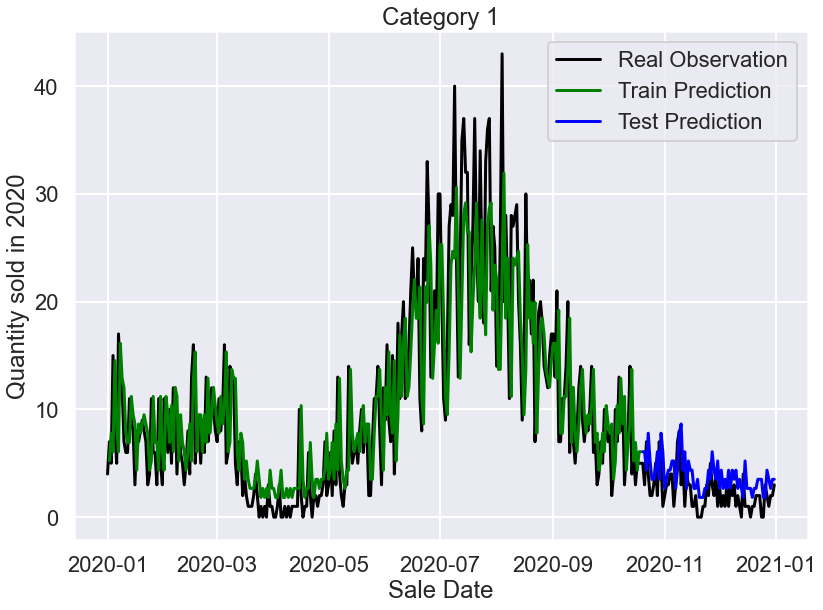

In [58]:
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(cat_lstm.index, scaler.inverse_transform(dataset), label='Real Observation', color='black')
ax.plot(cat_lstm.index, trainPredictPlot, label='Train Prediction', color='green')
ax.plot(cat_lstm.index, testPredictPlot, label='Test Prediction', color='blue')
plt.title('Category 1')
ax.set_xlabel('Sale Date')
ax.set_ylabel('Quantity sold in 2020')
ax.legend()
fig.tight_layout()
plt.savefig('images/lstm_1.jpeg', format='jpeg');

In [59]:
# calculate MAE and RMSE scores
trainScore_mae_1 = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae_1 = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks (look back = 1) train MAE: {:.2f}'.format(trainScore_mae_1))
print('LSTM Networks (look back = 1) test MAE: {:.2f}'.format(testScore_mae_1))
print('\n')
trainScore_1 = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore_1 = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks (look back = 1) train RMSE: {:.2f}'.format(trainScore_1))
print('LSTM Networks (look back = 1) test RMSE: {:.2f}'.format(testScore_1))


LSTM Networks (look back = 1) train MAE: 4.32
LSTM Networks (look back = 1) test MAE: 1.98


LSTM Networks (look back = 1) train RMSE: 5.64
LSTM Networks (look back = 1) test RMSE: 2.39


### look_back = 7

In [60]:
look_back = 7

In [61]:
train = dataset[:round(len(dataset) * 0.8)]
test = dataset[round(len(dataset) * 0.8) - look_back:]
test.shape

(80, 1)

In [62]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [63]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [64]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [65]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [66]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+look_back:len(dataset), :] = testPredict
# was testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

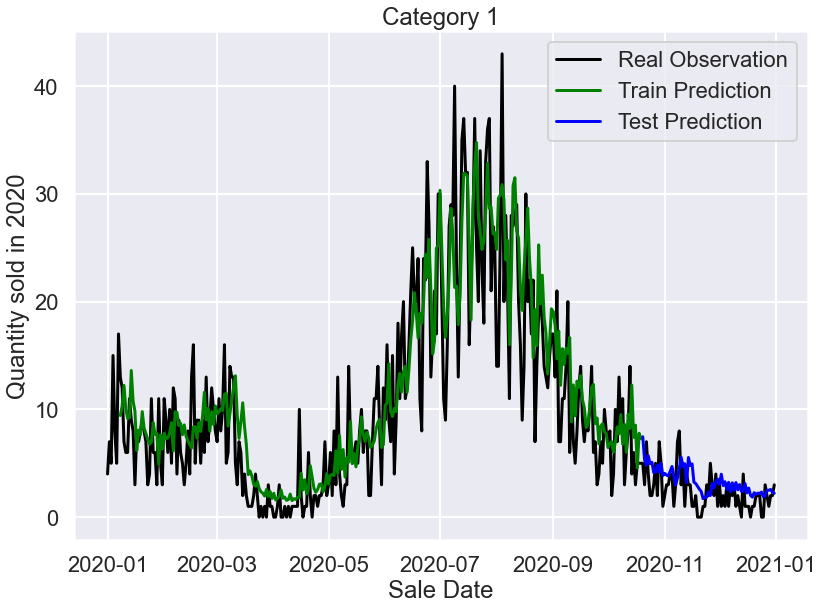

In [67]:
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(cat_lstm.index, scaler.inverse_transform(dataset), label='Real Observation', color='black')
ax.plot(cat_lstm.index, trainPredictPlot, label='Train Prediction', color='green')
ax.plot(cat_lstm.index, testPredictPlot, label='Test Prediction', color='blue')
plt.title('Category 1')
ax.set_xlabel('Sale Date')
ax.set_ylabel('Quantity sold in 2020')
ax.legend()
fig.tight_layout()
plt.savefig('images/lstm_7.jpeg', format='jpeg');

In [68]:
# calculate MAE and RMSE scores
trainScore_mae_7 = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae_7 = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks (look back = 7) train MAE: {:.2f}'.format(trainScore_mae_7))
print('LSTM Networks (look back = 7) test MAE: {:.2f}'.format(testScore_mae_7))
print('\n')
trainScore_7 = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore_7 = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks (look back = 7) train RMSE: {:.2f}'.format(trainScore_7))
print('LSTM Networks (look back = 7) test RMSE: {:.2f}'.format(testScore_7))

LSTM Networks (look back = 7) train MAE: 3.55
LSTM Networks (look back = 7) test MAE: 1.58


LSTM Networks (look back = 7) train RMSE: 4.56
LSTM Networks (look back = 7) test RMSE: 1.90


In [69]:
# LSTM Networks (look back = 7) train MAE: 3.40
# LSTM Networks (look back = 7) test MAE: 1.40


# LSTM Networks (look back = 7) train RMSE: 4.45
# LSTM Networks (look back = 7) test RMSE: 1.73

### look_back = 14

In [70]:
look_back = 14

In [71]:
train = dataset[:round(len(dataset) * 0.8)]
test = dataset[round(len(dataset) * 0.8) - look_back:]
test.shape

(87, 1)

In [72]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [73]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [74]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [75]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [76]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+look_back:len(dataset), :] = testPredict

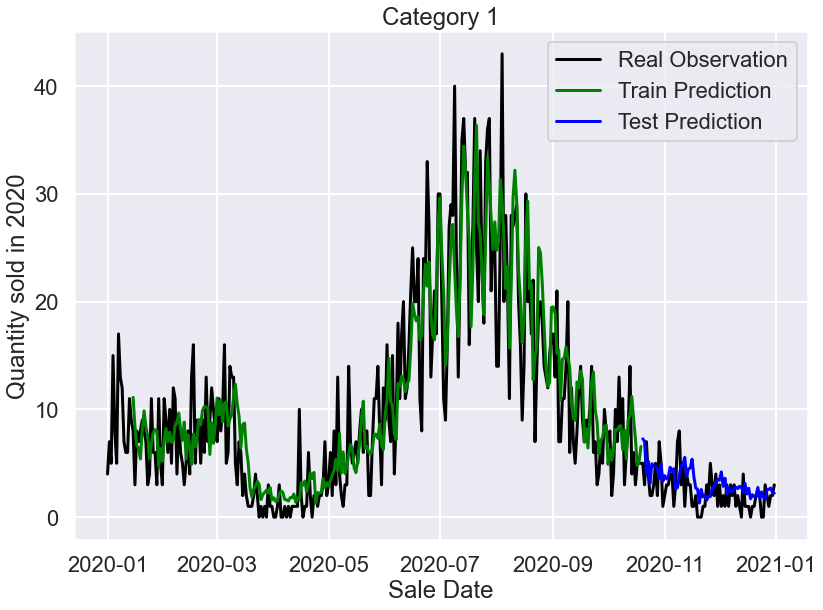

In [77]:
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(cat_lstm.index, scaler.inverse_transform(dataset), label='Real Observation', color='black')
ax.plot(cat_lstm.index, trainPredictPlot, label='Train Prediction', color='green')
ax.plot(cat_lstm.index, testPredictPlot, label='Test Prediction', color='blue')
plt.title('Category 1')
ax.set_xlabel('Sale Date')
ax.set_ylabel('Quantity sold in 2020')
ax.legend()
fig.tight_layout()
plt.savefig('images/lstm_14.jpeg', format='jpeg');

In [78]:
# calculate MAE and RMSE scores
trainScore_mae_14 = mean_absolute_error(trainY[0], trainPredict[:,0])
testScore_mae_14 = mean_absolute_error(testY[0], testPredict[:,0])
print('LSTM Networks (look back = 14) train MAE: {:.2f}'.format(trainScore_mae_14))
print('LSTM Networks (look back = 14) test MAE: {:.2f}'.format(testScore_mae_14))
print('\n')
trainScore_14 = mean_squared_error(trainY[0], trainPredict[:,0], squared=False)
testScore_14 = mean_squared_error(testY[0], testPredict[:,0], squared=False)
print('LSTM Networks (look back = 14) train RMSE: {:.2f}'.format(trainScore_14))
print('LSTM Networks (look back = 14) test RMSE: {:.2f}'.format(testScore_14))

LSTM Networks (look back = 14) train MAE: 3.28
LSTM Networks (look back = 14) test MAE: 1.57


LSTM Networks (look back = 14) train RMSE: 4.24
LSTM Networks (look back = 14) test RMSE: 1.96


In [79]:
# compare LSTM train / test MAE and RMSE scores
print('LSTM Networks (look back = 1) train MAE: {:.2f}'.format(trainScore_mae_1))
print('LSTM Networks (look back = 1) test MAE: {:.2f}'.format(testScore_mae_1))
print('\n')
print('LSTM Networks (look back = 7) train MAE: {:.2f}'.format(trainScore_mae_7))
print('LSTM Networks (look back = 7) test MAE: {:.2f}'.format(testScore_mae_7))
print('\n')
print('LSTM Networks (look back = 14) train MAE: {:.2f}'.format(trainScore_mae_14))
print('LSTM Networks (look back = 14) test MAE: {:.2f}'.format(testScore_mae_14))
print('\n')

print('LSTM Networks (look back = 1) train RMSE: {:.2f}'.format(trainScore_1))
print('LSTM Networks (look back = 1) test RMSE: {:.2f}'.format(testScore_1))
print('\n')
print('LSTM Networks (look back = 7) train RMSE: {:.2f}'.format(trainScore_7))
print('LSTM Networks (look back = 7) test RMSE: {:.2f}'.format(testScore_7))
print('\n')
print('LSTM Networks (look back = 14) train RMSE: {:.2f}'.format(trainScore_14))
print('LSTM Networks (look back = 14) test RMSE: {:.2f}'.format(testScore_14))
print('\n')

LSTM Networks (look back = 1) train MAE: 4.32
LSTM Networks (look back = 1) test MAE: 1.98


LSTM Networks (look back = 7) train MAE: 3.55
LSTM Networks (look back = 7) test MAE: 1.58


LSTM Networks (look back = 14) train MAE: 3.28
LSTM Networks (look back = 14) test MAE: 1.57


LSTM Networks (look back = 1) train RMSE: 5.64
LSTM Networks (look back = 1) test RMSE: 2.39


LSTM Networks (look back = 7) train RMSE: 4.56
LSTM Networks (look back = 7) test RMSE: 1.90


LSTM Networks (look back = 14) train RMSE: 4.24
LSTM Networks (look back = 14) test RMSE: 1.96


